In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Example: Stock price modeling

Time series modeling is particularly popular in finance; it's used to model the price movements of almost every asset and commodity. In this lesson, you'll use the techniques that you learned in order to model a currency exchange rate. Specifically, you'll model the value of the S&P 500 stock market index.

The data here comes from the [St. Louis Federal Reserve's database](https://fred.stlouisfed.org), which is affectionately known as *FRED*. You'll use the S&P 500 data for now, using nine years of data starting January 1, 2008.

In [2]:
sp_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/SP500_raw.csv')

# Convert exchange rate to a number, with coercion to throw `NA` values if conversion not possible
sp_data['price'] = pd.to_numeric(sp_data.SP500, errors='coerce')

# Remove `NA` values
sp_data.dropna(inplace=True)

In [3]:
sp_data.head()

,DATE,SP500,price
0,2008-01-02,1447.16,1447.16
1,2008-01-03,1447.16,1447.16
2,2008-01-04,1411.63,1411.63
3,2008-01-07,1416.18,1416.18
4,2008-01-08,1390.19,1390.19


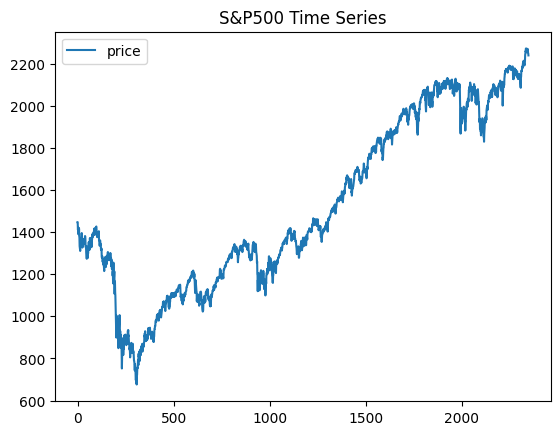

In [4]:
sp_data.plot()
plt.title('S&P500 Time Series')
plt.show()

So, now you have a time series of exchange-rate data. The x-axis in the graph above doesn't make much sense, though. How might you fix that?

You can use pandas to create a date-based index, as demonstrated here:

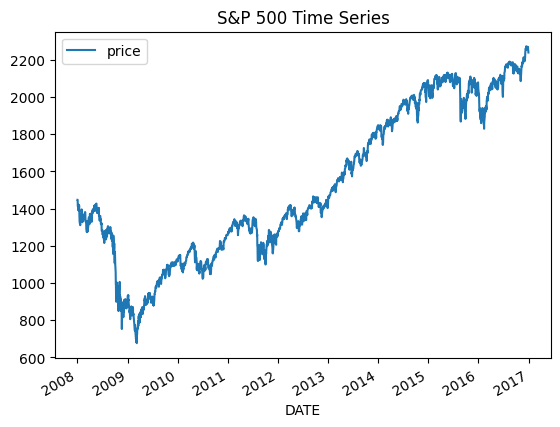

In [5]:
sp_data.index = pd.to_datetime(sp_data.DATE)
sp_data.plot()
plt.title('S&P 500 Time Series')
plt.show()

That's better. Now you have a sense of the amount of time that the time series actually covers. As discussed previously, however, you need a stationary dataset. This looks as though it might have a trend to it, so try plotting the difference:

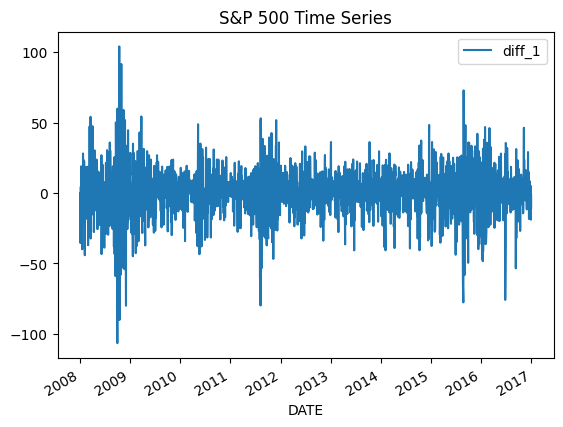

In [6]:
sp_data['diff_1'] = sp_data.price - sp_data.price.shift()
sp_data.plot(y='diff_1')
plt.title('S&P 500 Time Series')
plt.show()

You'll also want to investigate the PACF. Look at the PACF for both the initial and differenced time series:

Text(0.5, 1.0, 'S&P PACF')

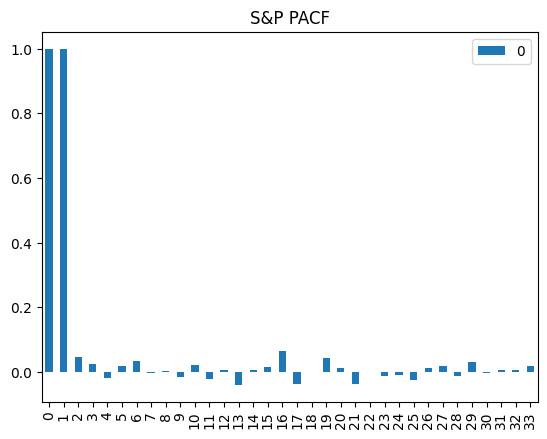

In [7]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(sp_data.price))
x_acf.plot(kind='bar')
plt.title("S&P PACF")

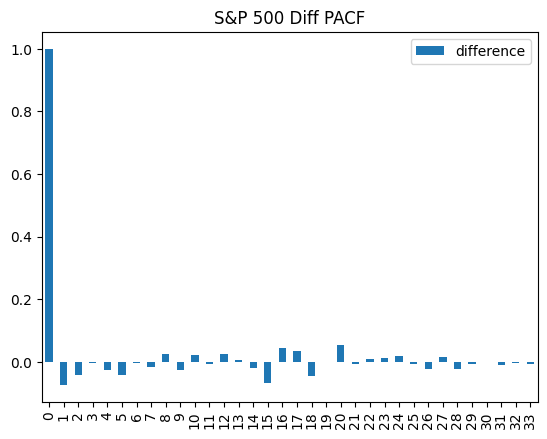

In [8]:
x_acf = pd.DataFrame(pacf(sp_data.diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("S&P 500 Diff PACF")
plt.legend(['difference'])

## Building models

So your initial time series has two strong autocorrelations, and the differences seem to show one autocorrelation. Now, build some ARIMA models to experiment, and see how you do!

You're going to build a series of models to evaluate, and each will have slightly different parameters for the ARIMA. Note that the parameters are passed in `(p, d, q)` order, corresponding to the AR, I, and MA portions, respectively.

Recall how those attributes are interpreted. The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

In [9]:
sp_data.index = pd.DatetimeIndex(sp_data.index).to_period('M')

In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(sp_data.price, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2267
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9602.651
Date:                Fri, 12 Jan 2024   AIC                          19207.303
Time:                        23:37:07   BIC                          19213.029
Sample:                    01-31-2008   HQIC                         19209.392
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       280.7728      4.845     57.953      0.000     271.277     290.269
Ljung-Box (L1) (Q):                  12.20   Jarque-Bera (JB):              1534.93
Prob(Q):                              0.00   Pr

In [11]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(sp_data.price, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2267
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -9610.391
Date:                Fri, 12 Jan 2024   AIC                          19226.781
Time:                        23:37:08   BIC                          19243.960
Sample:                    01-31-2008   HQIC                         19233.049
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1520.6520   2163.001      0.703      0.482   -2718.753    5760.057
ar.L1          0.9998      0.000   3305.284      0.000       0.999       1.000
sigma2       280.6389      4.884     57.461      0.0

In [12]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(sp_data.price, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2267
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -9604.436
Date:                Fri, 12 Jan 2024   AIC                          19216.873
Time:                        23:37:08   BIC                          19239.778
Sample:                    01-31-2008   HQIC                         19225.230
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1520.6520      0.001   2.85e+06      0.000    1520.651    1520.653
ar.L1          1.0000    8.7e-05   1.15e+04      0.000       1.000       1.000
ma.L1         -0.0795      0.014     -5.546      0.0

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model_111 = ARIMA(sp_data.price, order=(1,1,1))
model_111_fit = model_111.fit()
print(model_111_fit.summary())
print('Residuals Description')
print(model_111_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2267
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9593.712
Date:                Fri, 12 Jan 2024   AIC                          19193.423
Time:                        23:37:10   BIC                          19210.601
Sample:                    01-31-2008   HQIC                         19199.691
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5722      0.097      5.875      0.000       0.381       0.763
ma.L1         -0.6453      0.088     -7.294      0.000      -0.819      -0.472
sigma2       278.5604      4.883     57.049      0.0

In [14]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(sp_data.price, order=(5,1,5))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2267
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -9591.076
Date:                Fri, 12 Jan 2024   AIC                          19204.151
Time:                        23:37:25   BIC                          19267.135
Sample:                    01-31-2008   HQIC                         19227.132
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8142      0.098      8.310      0.000       0.622       1.006
ar.L2         -0.1481      0.086     -1.726      0.084      -0.316       0.020
ar.L3         -0.4025      0.080     -5.035      0.0

Now, you haven't covered all of the output given by the statsmodels summary function. (If you want to dive deeper, [Machine Learning Mastery's summary](http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) is a good place to start.) What you're most interested in here are the p-values of the coefficients, the log-likelihood, and the residuals statistics.

The *p-values* are a way of approximating the likelihood that the coefficient has a significant effect on your outcome. But again, it is formally a probability of more extreme results. It allows you to craft the 95% confidence interval for that coefficient. If `0` is within that interval, then that coefficient is often considered to be potentially unnecessary.

The *log-likelihood* is a log of the likelihood that the given model would generate the data that you see. The closer to `0`, the higher the probability that you can predict the outcome with your given model.

What you can tell from these models, however, is that the outcomes aren't great. There isn't a huge difference in performance across the models, and they all generally seem pretty weak.

## Residuals

The last thing to look at here is the residuals. Basically, *residuals* are what is left over when you build your model; they're the difference between your prediction and the observed quantity. In time series, residuals are typically pretty important. You want your residuals to be random and normally distributed. That's the assumption made about errors in linear modeling.

So how can you validate this?

Below, take a look at your ARIMA(1,1,1) residuals and see.

Text(0.5, 1.0, 'Histogram of Residuals')

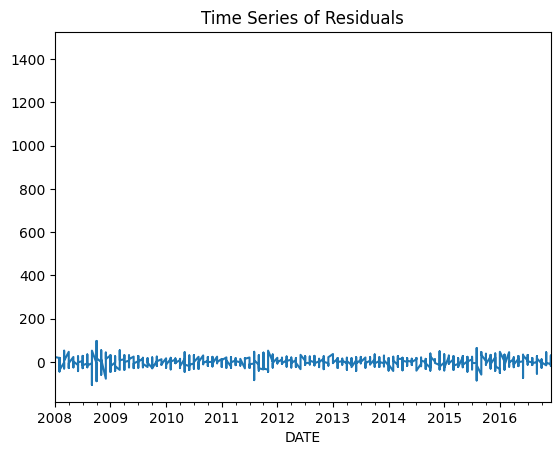

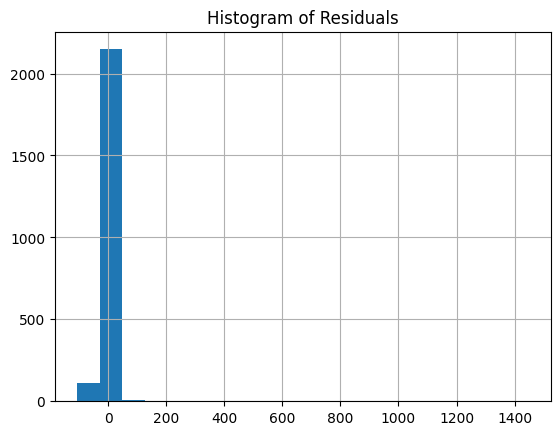

In [15]:
residuals = pd.DataFrame(model_111_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past.


When you look at these plots of the residuals, you can make two reasonable assumptions. Firstly, there isn't a clear trend in the residuals. There are definitely places of higher volatility, and your model could be expanded to include non-time-series elements that could account for that variation. (Here, that refers to typical regression coefficients, as in the linear modeling sections from earlier, though this would require a dataset that includes such features.) However, there isn't a clear trend to the data indicating an obviously missed seasonality.

Secondly, the residuals seem to approximate a normal distribution. There is a very long tail on the lower end, but that is a very small number of observations that are likely outliers or caused by some external influence.

## Interpreting the ARIMA (1,0,1)

Before you move on to the challenge for this section, return to model interpretation. You've spent this time building models, but you haven't really explored what the output means. Your ARIMA(1,0,1) makes a good example for a quick interpretation.

Firstly, the constant is approximately 1,700. Then, each day is approximately equal to the previous day's value; this is explained through the AR(1) coefficient being `0.9994`. The moving average term is approximately `-0.0787`; this means that by incorporating the moving average term in the model, the error present in the model will be reduced by about 8% per day. The moving average part indicates that the regression error is actually a linear combination of error terms whose values occurred both in the current time lag and at various times in the past.

Can you interpret the output of one of the other models? What about ARIMA(1,1,1)? Which do you prefer? Then try some of your own coefficients below.

In [16]:
# Reasonable Model

# The AR(2,1,1) coeffcient is a constant and the moving average term is approximately
# -0.7161. So, by incorporating the moving average term in the model, the error
# present in the model will be reduced by about 72% per day.
model = ARIMA(sp_data.price, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2267
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9593.574
Date:                Fri, 12 Jan 2024   AIC                          19195.149
Time:                        23:37:28   BIC                          19218.052
Sample:                    01-31-2008   HQIC                         19203.505
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6387      0.127      5.024      0.000       0.390       0.888
ar.L2          0.0157      0.020      0.769      0.442      -0.024       0.056
ma.L1         -0.7161      0.125     -5.729      0.0

## Comparing models with AIC

Now, you've generated a series of models. Which one works best?

Well, one of the easiest ways to compare time series models is with something called the *Akaike information criterion* (AIC). The AIC is a measure of the degree of information contained in the model, as you may recall from the discussion of information theory from when you learned about decision trees.

Conveniently, statsmodels [calculates the AIC](https://www.otexts.org/fpp/8/6) automatically. You want to minimize the value of the AIC; the model with the lowest AIC is likely the best model to choose. Just how *much* better is calculated using the ratios of AICs.

Once you've identified the model with the lowest AIC, you'll compare that model to other models using the probability of information loss. You can find the probability that another model minimizes information loss using the following calculation:

$$ exp((AIC_{min} - AIC_{x})/2) $$

This gives the probability of having lost less information with the other model.

From the examples, ARIMA(1,1,1) has an AIC of 19,193. Your worst model has an AIC of 19,225. (It's the ARIMA(1,0,0), or AR(1) model.) But how do these two models compare?

It turns out, when doing the above calculation, you get a probability of 1.125e-7 that you lost less information in the AR(1) model. That is a big difference and suggests that ARIMA(1,1,1) is a much better model.

Below, we will compare the other models to ARIMA(1,1,1) through grid search.

In [17]:
# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
 # Prepare training dataset
 train_size = int(len(X) * 0.66)
 train, test = X[0:train_size], X[train_size:]
 history = [x for x in train]

 # Make predictions
 predictions = list()
 for t in range(len(test)):
  model = ARIMA(history, order=arima_order)
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  history.append(test[t])

 # Calculate out of sample error
 error = mean_squared_error(test, predictions)
 return error

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
 dataset = dataset.astype('float32')
 best_score, best_cfg = float("inf"), None

 for p in p_values:
  for d in d_values:
    for q in q_values:
      order = (p,d,q)
      try:
        mse = evaluate_arima_model(dataset, order)
        if mse < best_score:
          best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order,mse))
      except:
        continue
 print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# Evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 3)
series = sp_data.price
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=397552.402
ARIMA(0, 0, 1) MSE=104472.704
ARIMA(0, 0, 2) MSE=33707.136
ARIMA(0, 1, 0) MSE=281.272


Upon completion, ARIMA(1,1,1) gives the lowest MSE.